In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

import os
os.chdir('/content/gdrive/MyDrive/ViralMut/')

Mounted at /content/gdrive


In [2]:
import warnings

warnings.filterwarnings('ignore')

!mkdir -p ~/.fonts
!cp arial.ttf ~/.fonts/
!fc-cache -fv

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [3]:
from matplotlib import font_manager as fm

font_dir = os.path.join(os.environ['HOME'], '.fonts')
os.makedirs(font_dir, exist_ok=True)
font_name = 'arial.ttf'
font_path = os.path.join(font_dir, font_name)
fm.fontManager.addfont(font_path)

!cp {font_name} {font_dir}

## 1. Load data

In [4]:
import pandas as pd

normal_prot = pd.read_csv('./ClinMAVE/LLR/normal_LLR_results.csv')
normal_gene = pd.read_csv('./ClinMAVE/LLR/normal_LLR_CaLM_results.csv')

lof_prot = pd.read_csv('./ClinMAVE/LLR/lof_LLR_results.csv')
lof_gene = pd.read_csv('./ClinMAVE/LLR/lof_LLR_CaLM_results.csv')

gof_prot = pd.read_csv('./ClinMAVE/LLR/gof_LLR_results.csv')
gof_gene = pd.read_csv('./ClinMAVE/LLR/gof_LLR_CaLM_results.csv')

In [5]:
normal_prot = normal_prot.add_suffix('_prot')
normal_gene = normal_gene.add_suffix('_gene')

lof_prot = lof_prot.add_suffix('_prot')
lof_gene = lof_gene.add_suffix('_gene')

gof_prot = gof_prot.add_suffix('_prot')
gof_gene = gof_gene.add_suffix('_gene')

In [6]:
merged_normal = pd.concat([normal_prot.reset_index(drop=True),
                           normal_gene.reset_index(drop=True)],
                          axis=1)

merged_lof = pd.concat([lof_prot.reset_index(drop=True),
                               lof_gene.reset_index(drop=True)],
                              axis=1)

merged_gof = pd.concat([gof_prot.reset_index(drop=True),
                        gof_gene.reset_index(drop=True)],
                        axis=1)

In [7]:
filtered_lof = merged_lof.dropna(subset=['LLR_prot', 'LLR_gene'])
filtered_normal = merged_normal.dropna(subset=['LLR_prot', 'LLR_gene'])
filtered_gof = merged_gof.dropna(subset=['LLR_prot', 'LLR_gene'])

LLR_lof_prot = filtered_lof['LLR_prot'].tolist()
LLR_lof_gene = filtered_lof['LLR_gene'].tolist()

LLR_normal_prot = filtered_normal['LLR_prot'].tolist()
LLR_normal_gene = filtered_normal['LLR_gene'].tolist()

LLR_gof_prot = filtered_gof['LLR_prot'].tolist()
LLR_gof_gene = filtered_gof['LLR_gene'].tolist()

# Functionally normal vs. LoF

## 2. Bayesian optimization

In [8]:
!pip install bayesian-optimization

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedGroupKFold
from bayes_opt import BayesianOptimization

def run_cv_with_gene_split(X_gene, X_prot, y, groups, n_splits=10):

    X_gene = np.array(X_gene)
    X_prot = np.array(X_prot)
    y = np.array(y)
    groups = np.array(groups)

    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=18)

    mean_fpr = np.linspace(0, 1, 100)
    mean_recall = np.linspace(0, 1, 100)

    results = {
        'Hybrid': {'tprs': [], 'rocs': [], 'weights': [], 'precisions': [], 'prs': [], 'pool_scores': []},
        'CaLM':   {'tprs': [], 'rocs': [],                'precisions': [], 'prs': [], 'pool_scores': []},
        'ESM-2':  {'tprs': [], 'rocs': [],                'precisions': [], 'prs': [], 'pool_scores': []},
        'BO_History': [],
        'pool_y': []
    }

    for fold_i, (train_idx, test_idx) in enumerate(cv.split(X_gene, y, groups=groups)):

        X_gene_train, X_gene_test = X_gene[train_idx], X_gene[test_idx]
        X_prot_train, X_prot_test = X_prot[train_idx], X_prot[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]


        def get_roc_for_w(w, Xg, Xp, y_t):
            s = w * Xg + (1 - w) * Xp

            return roc_auc_score(y_t, -s)

        def bo_target(w):

            return get_roc_for_w(w, X_gene_train, X_prot_train, y_train)

        optimizer = BayesianOptimization(f=bo_target, pbounds={'w': (0, 1)}, random_state=25, verbose=0)
        optimizer.maximize(init_points=10, n_iter=20)

        best_w = optimizer.max['params']['w']
        results['Hybrid']['weights'].append(best_w)


        w_grid = np.linspace(0, 1, 100)
        roc_landscape = [get_roc_for_w(w, X_gene_train, X_prot_train, y_train) for w in w_grid]


        bo_sampled_w = [res['params']['w'] for res in optimizer.res]
        bo_sampled_roc = [res['target'] for res in optimizer.res]

        results['BO_History'].append({
            'fold': fold_i,
            'w_grid': w_grid,
            'roc_landscape': roc_landscape,
            'sampled_w': bo_sampled_w,
            'sampled_roc': bo_sampled_roc,
            'best_w': best_w,
            'best_roc': optimizer.max['target']
        })

        results['pool_y'].extend(y_test)

        def cal_metrics(name, scores):

            fpr, tpr, _ = roc_curve(y_test, scores)
            roc_auc = auc(fpr, tpr)

            results[name]['pool_scores'].extend(scores)

            results[name]['tprs'].append(np.interp(mean_fpr, fpr, tpr))
            results[name]['tprs'][-1][0] = 0.0
            results[name]['rocs'].append(roc_auc)

            precision, recall, _ = precision_recall_curve(y_test, scores)
            ap = average_precision_score(y_test, scores)

            interp_prec = np.interp(mean_recall, recall[::-1], precision[::-1])

            results[name]['precisions'].append(interp_prec)
            results[name]['prs'].append(ap)


        s_test_hybrid = best_w * X_gene_test + (1 - best_w) * X_prot_test
        cal_metrics('Hybrid', -s_test_hybrid)
        cal_metrics('CaLM', -X_gene_test)
        cal_metrics('ESM-2', -X_prot_test)

        print(f"Fold {fold_i+1}: Best w={best_w:.2f}, ROC={results['Hybrid']['rocs'][-1]:.3f}, PR={results['Hybrid']['prs'][-1]:.3f}")

    return results, mean_fpr, mean_recall

## 3. Statistical summary

In [10]:
# normal as "Negative" class (Class 0)
gene_neg = np.concatenate([LLR_normal_gene])
prot_neg = np.concatenate([LLR_normal_prot])

# LoF as "Positive" class
gene_pos = np.concatenate([LLR_lof_gene])
prot_pos = np.concatenate([LLR_lof_prot])

X_gene = np.concatenate([gene_neg, gene_pos]) # X_gene: CaLM LLRs
X_prot = np.concatenate([prot_neg, prot_pos]) # X_prot: ESM-2 LLRs
y_true = np.concatenate([np.zeros(len(gene_neg)), np.ones(len(gene_pos))])

print(f"Total samples: {len(y_true)} (Pos: {np.sum(y_true)}, Neg: {len(y_true)-np.sum(y_true)})")

# Calculate statistical properties
mean_gene, std_gene = np.mean(X_gene), np.std(X_gene)
mean_prot, std_prot = np.mean(X_prot), np.std(X_prot)

print(f"CaLM LLR  -> Mean: {mean_gene:.4f}, Std Dev: {std_gene:.4f}")
print(f"ESM-2 LLR -> Mean: {mean_prot:.4f}, Std Dev: {std_prot:.4f}")

# Calculate the scale ratio
scale_ratio = std_gene / std_prot
print(f"Scale Ratio (Std_Gene / Std_Prot): {scale_ratio:.4f}")

groups_gene = np.concatenate([filtered_normal['Gene_prot'], filtered_lof['Gene_prot']])

Total samples: 250841 (Pos: 74038.0, Neg: 176803.0)
CaLM LLR  -> Mean: -6.2293, Std Dev: 2.6136
ESM-2 LLR -> Mean: -5.9720, Std Dev: 2.8381
Scale Ratio (Std_Gene / Std_Prot): 0.9209


## 4. 10-fold CV

In [11]:
results, mean_fpr, mean_recall = run_cv_with_gene_split(X_gene, X_prot, y_true, groups_gene)

Fold 1: Best w=0.13, ROC=0.747, PR=0.588
Fold 2: Best w=0.14, ROC=0.720, PR=0.561
Fold 3: Best w=0.09, ROC=0.762, PR=0.647
Fold 4: Best w=0.12, ROC=0.777, PR=0.639
Fold 5: Best w=0.13, ROC=0.749, PR=0.664
Fold 6: Best w=0.14, ROC=0.737, PR=0.567
Fold 7: Best w=0.13, ROC=0.721, PR=0.475
Fold 8: Best w=0.10, ROC=0.745, PR=0.524
Fold 9: Best w=0.14, ROC=0.709, PR=0.453
Fold 10: Best w=0.16, ROC=0.767, PR=0.603


## 5. Validation

Hybrid vs CaLM: P-value = 1.64e-07
Hybrid vs ESM-2: P-value = 1.42e-01


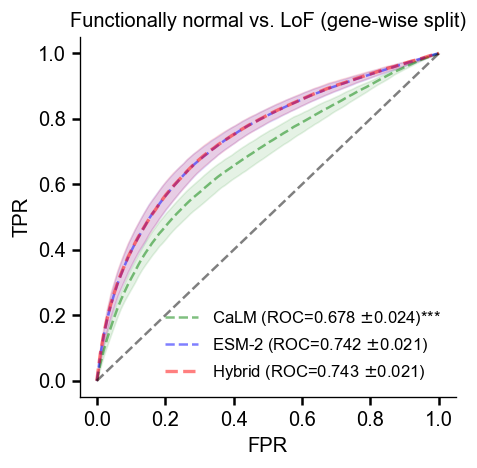

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import numpy as np
import scipy.stats as st

def get_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

aucs_base = results['Hybrid']['rocs']

p_values = {}

for name in ['CaLM', 'ESM-2']:
    aucs_curr = results[name]['rocs']
    stat, p_val = st.ttest_rel(aucs_base, aucs_curr)

    p_values[name] = p_val
    print(f"Hybrid vs {name}: P-value = {p_val:.2e}")


plt.figure(figsize=(4, 4), dpi=120)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

ax = plt.gca()

colors = {'Hybrid': 'red', 'ESM-2': 'blue', 'CaLM': 'green'}
styles = {'Hybrid': '--', 'ESM-2': '--', 'CaLM': '--'}


for name in ['CaLM', 'ESM-2', 'Hybrid']:

    mean_tpr = np.mean(results[name]['tprs'], axis=0)
    mean_tpr[-1] = 1.0

    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(results[name]['rocs'])

    if name == 'Hybrid':
        label_str = f"{name} (ROC={mean_auc:.3f} $\pm${std_auc:.3f})"
        linestyle = '--'
        linewidth = 2

    else:
        p = p_values[name]
        stars = get_stars(p)
        label_str = f"{name} (ROC={mean_auc:.3f} $\pm${std_auc:.3f}){stars}"
        linestyle = styles[name]
        linewidth = 1.5

    plt.plot(mean_fpr, mean_tpr, color=colors[name], ls=linestyle, lw=linewidth, alpha=0.5,
             label=label_str)

    std_tpr = np.std(results[name]['tprs'], axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[name], alpha=0.1)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)

plt.xlabel('FPR', fontsize=12)
plt.ylabel('TPR', fontsize=12)
plt.title('Functionally normal vs. LoF (gene-wise split)', fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc="lower right",frameon=False)
plt.tight_layout()
plt.show()

Paired T-test: Hybrid vs ESM-2, p=1.20e-01
Paired T-test: Hybrid vs CaLM,  p=1.26e-07


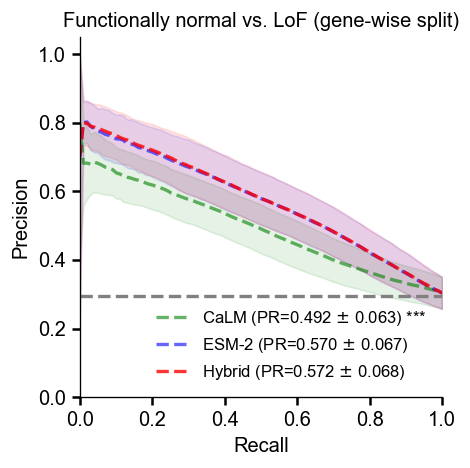

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

ap_hyb_folds = np.array(results['Hybrid']['prs'])
ap_esm_folds = np.array(results['ESM-2']['prs'])
ap_calm_folds = np.array(results['CaLM']['prs'])

p_val_esm  = ttest_rel(ap_hyb_folds, ap_esm_folds).pvalue
p_val_calm = ttest_rel(ap_hyb_folds, ap_calm_folds).pvalue

print(f"Paired T-test: Hybrid vs ESM-2, p={p_val_esm:.2e}")
print(f"Paired T-test: Hybrid vs CaLM,  p={p_val_calm:.2e}")

def get_sig_symbol(p):
    if p is None: return ""
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return ""

p_vals = {'Hybrid': None, 'ESM-2': p_val_esm, 'CaLM': p_val_calm}


plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.figure(figsize=(4, 4), dpi=120)
ax = plt.gca()

colors = {'Hybrid': 'red', 'ESM-2': 'blue', 'CaLM': 'green'}
labels = {'Hybrid': 'Hybrid', 'CaLM': 'CaLM', 'ESM-2': 'ESM-2'}


for model in ['CaLM', 'ESM-2', 'Hybrid']:

    precisions_matrix = np.array(results[model]['precisions'])

    mean_precision = np.mean(precisions_matrix, axis=0)
    std_precision = np.std(precisions_matrix, axis=0)

    mean_ap = np.mean(results[model]['prs'])
    std_ap = np.std(results[model]['prs'])

    label_str = f'{labels[model]} (PR={mean_ap:.3f} $\pm$ {std_ap:.3f})'

    if model != 'Hybrid':
        sig = get_sig_symbol(p_vals[model])
        label_str += f" {sig}"
    else:
        label_str += ""

    plt.plot(mean_recall, mean_precision, ls='--',
             label=label_str,
             color=colors[model], lw=2, alpha=0.8 if model=='Hybrid' else 0.6)

    plt.fill_between(mean_recall,
                     np.maximum(mean_precision - std_precision, 0),
                     np.minimum(mean_precision + std_precision, 1),
                     color=colors[model], alpha=0.1)

baseline = np.sum(y_true == 1) / len(y_true)
plt.plot([0, 1], [baseline, baseline], linestyle='--', lw=2, color='gray')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Functionally normal vs. LoF (gene-wise split)', fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.legend(loc="lower right", frameon=False, fontsize=10)
plt.tight_layout()
plt.show()

## 6. Training

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

colors = {
'line': '#3C5488',
'shade': '#3C5488',
'sample': '#E64B35',
'best': '#DC0000',
'rug': '#00A087',
'gray': '#7E6148'
}

def style_ax(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    ax.tick_params(axis='both', which='major', labelsize=10, width=1, length=5)

def plot_fold_grid(results):

    fig, axes = plt.subplots(5, 2, figsize=(6, 8), dpi=150,
                             sharex=True, sharey=True)
    axes = axes.flatten()

    for i, bo_data in enumerate(results['BO_History']):
        ax = axes[i]
        style_ax(ax)

        ax.set_ylim(0.6, 0.8)

        ax.plot(bo_data['w_grid'], bo_data['roc_landscape'],
                color='gray', alpha=0.6, lw=1, linestyle='-', zorder=1,
                label='Optimization Landscape' if i == 0 else "")

        ax.scatter(bo_data['sampled_w'], bo_data['sampled_roc'],
                   color=colors['sample'], s=25, alpha=0.6, linewidth=0.5, zorder=2,
                   label='BO Samples' if i == 0 else "")

        ax.scatter(bo_data['best_w'], bo_data['best_roc'],
                   color=colors['best'], marker='*', s=50, zorder=10, linewidth=1,
                   label='Best weight' if i == 0 else "")

        ax.text(0.95, 0.05, f"w={bo_data['best_w']:.2f}",
                transform=ax.transAxes, fontsize=8,
                ha='right', va='bottom', color='#333333')

        ax.set_title(f"Fold {i+1}", fontsize=10, pad=5, loc='center')


    fig.supxlabel(r'Weight for CaLM', fontsize=10, y=0.1)
    fig.supylabel('ROC (Training)', fontsize=10, x=0.02)


    handles, labels = axes[0].get_legend_handles_labels()

    plt.subplots_adjust(top=0.95, bottom=0.15, left=0.15, right=0.95, hspace=0.3, wspace=0.1)


    plt.show()

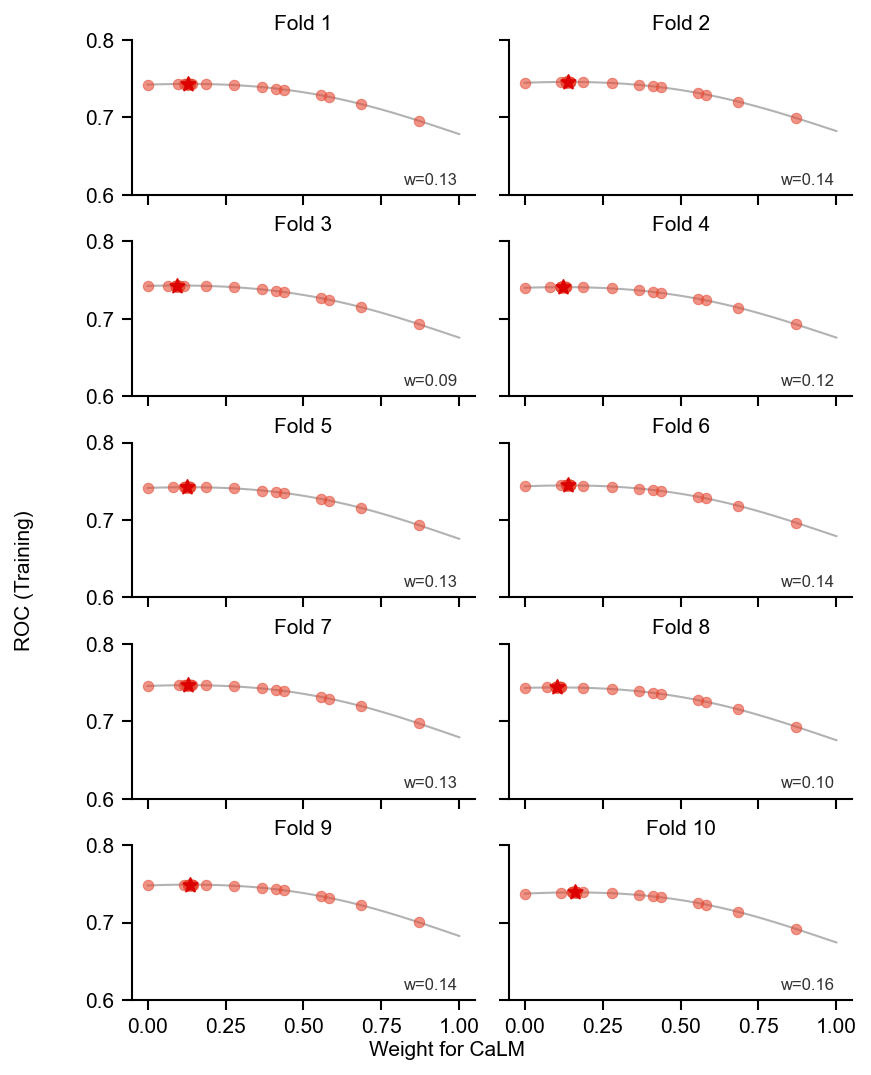

In [15]:
plot_fold_grid(results)

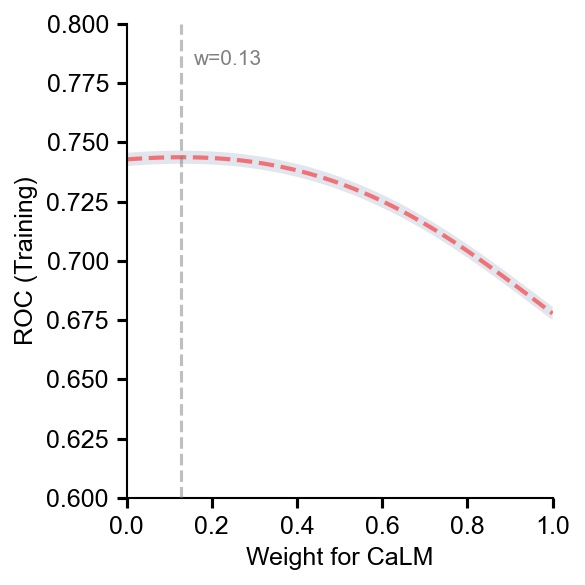

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

def style_ax(ax):

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=5, colors='black')


def plot_aggregated_landscape(results):

    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
    style_ax(ax)

    w_grid = results['BO_History'][0]['w_grid']
    landscape_matrix = np.array([fold['roc_landscape'] for fold in results['BO_History']])
    best_ws = [fold['best_w'] for fold in results['BO_History']]

    mean_auc = np.mean(landscape_matrix, axis=0)
    std_auc = np.std(landscape_matrix, axis=0)
    mean_best_w = np.mean(best_ws)

    ax.plot(w_grid, mean_auc, color='red', lw=2, alpha = 0.5, linestyle='--')

    ax.fill_between(w_grid, mean_auc - std_auc, mean_auc + std_auc,
                    color=colors['shade'], alpha=0.15, edgecolor='none')

    ax.axvline(mean_best_w, color='gray', linestyle='--', alpha=0.5, lw=1.5, zorder=5)

    text_x = mean_best_w + 0.03
    text_y = 0.785
    ha_align = 'left'

    if mean_best_w > 0.75:
        text_x = mean_best_w - 0.03
        ha_align = 'right'

    ax.text(text_x, text_y,
            f'w={mean_best_w:.2f}',
            color='gray',
            fontsize=10,
            fontweight='bold',
            ha=ha_align,
            va='center',
            )

    ax.set_ylim(0.6, 0.8)
    ax.set_xlim(0, 1)

    ax.set_xlabel(r'Weight for CaLM', fontsize=12)
    ax.set_ylabel('ROC (Training)', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_aggregated_landscape(results)

# Functionally normal vs. GoF

In [17]:
from sklearn.model_selection import StratifiedKFold


def run_cv_with_random_split(X_gene, X_prot, y, n_splits=10):

    X_gene = np.array(X_gene)
    X_prot = np.array(X_prot)
    y = np.array(y)

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=18)

    mean_fpr = np.linspace(0, 1, 100)
    mean_recall = np.linspace(0, 1, 100)

    results = {
        'Hybrid': {'tprs': [], 'rocs': [], 'weights': [], 'precisions': [], 'prs': [], 'pool_scores': []},
        'CaLM':   {'tprs': [], 'rocs': [],                'precisions': [], 'prs': [], 'pool_scores': []},
        'ESM-2':  {'tprs': [], 'rocs': [],                'precisions': [], 'prs': [], 'pool_scores': []},
        'BO_History': [],
        'pool_y': []
    }

    for fold_i, (train_idx, test_idx) in enumerate(cv.split(X_gene, y)):

        X_gene_train, X_gene_test = X_gene[train_idx], X_gene[test_idx]
        X_prot_train, X_prot_test = X_prot[train_idx], X_prot[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]


        def get_roc_for_w(w, Xg, Xp, y_t):
            s = w * Xg + (1 - w) * Xp

            return roc_auc_score(y_t, -s)

        def bo_target(w):

            return get_roc_for_w(w, X_gene_train, X_prot_train, y_train)

        optimizer = BayesianOptimization(f=bo_target, pbounds={'w': (0, 1)}, random_state=25, verbose=0)
        optimizer.maximize(init_points=10, n_iter=20)

        best_w = optimizer.max['params']['w']
        results['Hybrid']['weights'].append(best_w)


        w_grid = np.linspace(0, 1, 100)
        roc_landscape = [get_roc_for_w(w, X_gene_train, X_prot_train, y_train) for w in w_grid]


        bo_sampled_w = [res['params']['w'] for res in optimizer.res]
        bo_sampled_roc = [res['target'] for res in optimizer.res]

        results['BO_History'].append({
            'fold': fold_i,
            'w_grid': w_grid,
            'roc_landscape': roc_landscape,
            'sampled_w': bo_sampled_w,
            'sampled_roc': bo_sampled_roc,
            'best_w': best_w,
            'best_roc': optimizer.max['target']
        })

        results['pool_y'].extend(y_test)

        def cal_metrics(name, scores):

            fpr, tpr, _ = roc_curve(y_test, scores)
            roc_auc = auc(fpr, tpr)

            results[name]['pool_scores'].extend(scores)

            results[name]['tprs'].append(np.interp(mean_fpr, fpr, tpr))
            results[name]['tprs'][-1][0] = 0.0
            results[name]['rocs'].append(roc_auc)

            precision, recall, _ = precision_recall_curve(y_test, scores)
            ap = average_precision_score(y_test, scores)

            interp_prec = np.interp(mean_recall, recall[::-1], precision[::-1])

            results[name]['precisions'].append(interp_prec)
            results[name]['prs'].append(ap)


        s_test_hybrid = best_w * X_gene_test + (1 - best_w) * X_prot_test
        cal_metrics('Hybrid', -s_test_hybrid)
        cal_metrics('CaLM', -X_gene_test)
        cal_metrics('ESM-2', -X_prot_test)

        print(f"Fold {fold_i+1}: Best w={best_w:.2f}, ROC={results['Hybrid']['rocs'][-1]:.3f}, PR={results['Hybrid']['prs'][-1]:.3f}")

    return results, mean_fpr, mean_recall

In [18]:
# normal as "Negative" class (Class 0)
gene_neg = np.concatenate([LLR_normal_gene])
prot_neg = np.concatenate([LLR_normal_prot])

# GoF as "Positive" class
gene_pos = np.concatenate([LLR_gof_gene])
prot_pos = np.concatenate([LLR_gof_prot])

X_gene = np.concatenate([gene_neg, gene_pos]) # X_gene: CaLM LLRs
X_prot = np.concatenate([prot_neg, prot_pos]) # X_prot: ESM-2 LLRs
y_true = np.concatenate([np.zeros(len(gene_neg)), np.ones(len(gene_pos))])

print(f"Total samples: {len(y_true)} (Pos: {np.sum(y_true)}, Neg: {len(y_true)-np.sum(y_true)})")

# Calculate statistical properties
mean_gene, std_gene = np.mean(X_gene), np.std(X_gene)
mean_prot, std_prot = np.mean(X_prot), np.std(X_prot)

print(f"CaLM LLR  -> Mean: {mean_gene:.4f}, Std Dev: {std_gene:.4f}")
print(f"ESM-2 LLR -> Mean: {mean_prot:.4f}, Std Dev: {std_prot:.4f}")

# Calculate the scale ratio
scale_ratio = std_gene / std_prot
print(f"Scale Ratio (Std_Gene / Std_Prot): {scale_ratio:.4f}")

Total samples: 179040 (Pos: 2237.0, Neg: 176803.0)
CaLM LLR  -> Mean: -5.7298, Std Dev: 2.3535
ESM-2 LLR -> Mean: -5.2406, Std Dev: 2.4356
Scale Ratio (Std_Gene / Std_Prot): 0.9663


In [19]:
results, mean_fpr, mean_recall = run_cv_with_random_split(X_gene, X_prot, y_true)

Fold 1: Best w=0.56, ROC=0.623, PR=0.026
Fold 2: Best w=0.50, ROC=0.587, PR=0.024
Fold 3: Best w=0.57, ROC=0.596, PR=0.021
Fold 4: Best w=0.55, ROC=0.533, PR=0.020
Fold 5: Best w=0.58, ROC=0.566, PR=0.022
Fold 6: Best w=0.53, ROC=0.579, PR=0.022
Fold 7: Best w=0.55, ROC=0.582, PR=0.023
Fold 8: Best w=0.59, ROC=0.566, PR=0.020
Fold 9: Best w=0.57, ROC=0.563, PR=0.019
Fold 10: Best w=0.57, ROC=0.581, PR=0.020


Hybrid vs CaLM: P-value = 4.95e-02
Hybrid vs ESM-2: P-value = 7.83e-03


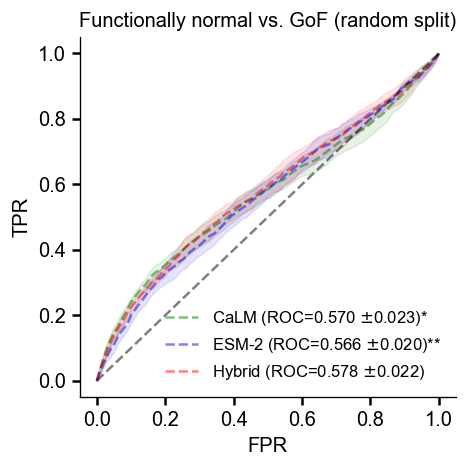

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import numpy as np
import scipy.stats as st

def get_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

aucs_base = results['Hybrid']['rocs']

p_values = {}

for name in ['CaLM', 'ESM-2']:
    aucs_curr = results[name]['rocs']

    stat, p_val = st.ttest_rel(aucs_base, aucs_curr)

    p_values[name] = p_val
    print(f"Hybrid vs {name}: P-value = {p_val:.2e}")


plt.figure(figsize=(4, 4), dpi=120)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

ax = plt.gca()

colors = {'Hybrid': 'red', 'ESM-2': 'blue', 'CaLM': 'green'}
styles = {'Hybrid': '--', 'ESM-2': '--', 'CaLM': '--'}


for name in ['CaLM', 'ESM-2', 'Hybrid']:

    mean_tpr = np.mean(results[name]['tprs'], axis=0)
    mean_tpr[-1] = 1.0

    mean_auc = auc(mean_fpr, mean_tpr)

    std_auc = np.std(results[name]['rocs'])

    if name == 'Hybrid':

        label_str = f"{name} (ROC={mean_auc:.3f} $\pm${std_auc:.3f})"
        linestyle = '--'
        linewidth = 1.5
    else:

        p = p_values[name]
        stars = get_stars(p)
        label_str = f"{name} (ROC={mean_auc:.3f} $\pm${std_auc:.3f}){stars}"
        linestyle = styles[name]
        linewidth = 1.5

    plt.plot(mean_fpr, mean_tpr, color=colors[name], ls=linestyle, lw=linewidth, alpha=0.5,
             label=label_str)

    std_tpr = np.std(results[name]['tprs'], axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[name], alpha=0.1)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)

plt.xlabel('FPR', fontsize=12)
plt.ylabel('TPR', fontsize=12)
plt.title('Functionally normal vs. GoF (random split)', fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc="lower right",frameon=False)
plt.tight_layout()
plt.show()

Paired T-test: Hybrid vs ESM-2, p=2.03e-03
Paired T-test: Hybrid vs CaLM,  p=6.48e-02


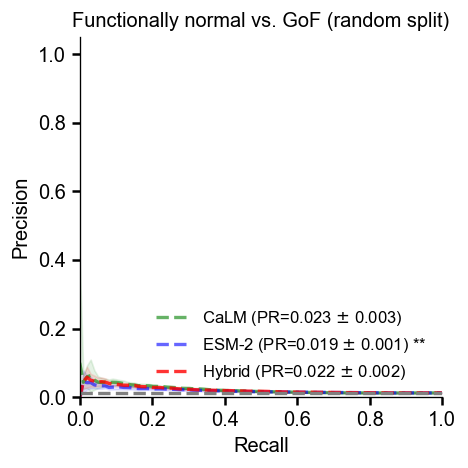

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

ap_hyb_folds = np.array(results['Hybrid']['prs'])
ap_esm_folds = np.array(results['ESM-2']['prs'])
ap_calm_folds = np.array(results['CaLM']['prs'])

p_val_esm  = ttest_rel(ap_hyb_folds, ap_esm_folds).pvalue
p_val_calm = ttest_rel(ap_hyb_folds, ap_calm_folds).pvalue

print(f"Paired T-test: Hybrid vs ESM-2, p={p_val_esm:.2e}")
print(f"Paired T-test: Hybrid vs CaLM,  p={p_val_calm:.2e}")

def get_sig_symbol(p):
    if p is None: return ""
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return ""

p_vals = {'Hybrid': None, 'ESM-2': p_val_esm, 'CaLM': p_val_calm}


plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.figure(figsize=(4, 4), dpi=120)
ax = plt.gca()

colors = {'Hybrid': 'red', 'ESM-2': 'blue', 'CaLM': 'green'}
labels = {'Hybrid': 'Hybrid', 'CaLM': 'CaLM', 'ESM-2': 'ESM-2'}


for model in ['CaLM', 'ESM-2', 'Hybrid']:

    precisions_matrix = np.array(results[model]['precisions'])

    mean_precision = np.mean(precisions_matrix, axis=0)
    std_precision = np.std(precisions_matrix, axis=0)

    mean_ap = np.mean(results[model]['prs'])
    std_ap = np.std(results[model]['prs'])

    label_str = f'{labels[model]} (PR={mean_ap:.3f} $\pm$ {std_ap:.3f})'

    if model != 'Hybrid':
        sig = get_sig_symbol(p_vals[model])
        label_str += f" {sig}"
    else:
        label_str += ""

    plt.plot(mean_recall, mean_precision, ls='--',
             label=label_str,
             color=colors[model], lw=2, alpha=0.8 if model=='Hybrid' else 0.6)

    plt.fill_between(mean_recall,
                     np.maximum(mean_precision - std_precision, 0),
                     np.minimum(mean_precision + std_precision, 1),
                     color=colors[model], alpha=0.1)

baseline = np.sum(y_true == 1) / len(y_true)
plt.plot([0, 1], [baseline, baseline], linestyle='--', lw=2, color='gray')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Functionally normal vs. GoF (random split)', fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.legend(loc="lower right", frameon=False, fontsize=10)
plt.tight_layout()
plt.show()

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

colors = {
'line': '#3C5488',
'shade': '#3C5488',
'sample': '#E64B35',
'best': '#DC0000',
'rug': '#00A087',
'gray': '#7E6148'
}

def style_ax(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    ax.tick_params(axis='both', which='major', labelsize=10, width=1, length=5)

def plot_fold_grid(results):

    fig, axes = plt.subplots(5, 2, figsize=(6, 8), dpi=150,
                             sharex=True, sharey=True)
    axes = axes.flatten()

    for i, bo_data in enumerate(results['BO_History']):
        ax = axes[i]
        style_ax(ax)

        ax.set_ylim(0.5, 0.6)

        ax.plot(bo_data['w_grid'], bo_data['roc_landscape'],
                color='gray', alpha=0.6, lw=1, linestyle='-', zorder=1,
                label='Optimization Landscape' if i == 0 else "")

        ax.scatter(bo_data['sampled_w'], bo_data['sampled_roc'],
                   color=colors['sample'], s=25, alpha=0.6, linewidth=0.5, zorder=2,
                   label='BO Samples' if i == 0 else "")

        ax.scatter(bo_data['best_w'], bo_data['best_roc'],
                   color=colors['best'], marker='*', s=50, zorder=10, linewidth=1,
                   label='Best weight' if i == 0 else "")

        ax.text(0.95, 0.05, f"w={bo_data['best_w']:.2f}",
                transform=ax.transAxes, fontsize=8,
                ha='right', va='bottom', color='#333333')

        ax.set_title(f"Fold {i+1}", fontsize=10, pad=5, loc='center')


    fig.supxlabel(r'Weight for CaLM', fontsize=10, y=0.1)
    fig.supylabel('ROC (Training)', fontsize=10, x=0.02)


    handles, labels = axes[0].get_legend_handles_labels()

    plt.subplots_adjust(top=0.95, bottom=0.15, left=0.15, right=0.95, hspace=0.3, wspace=0.1)


    plt.show()

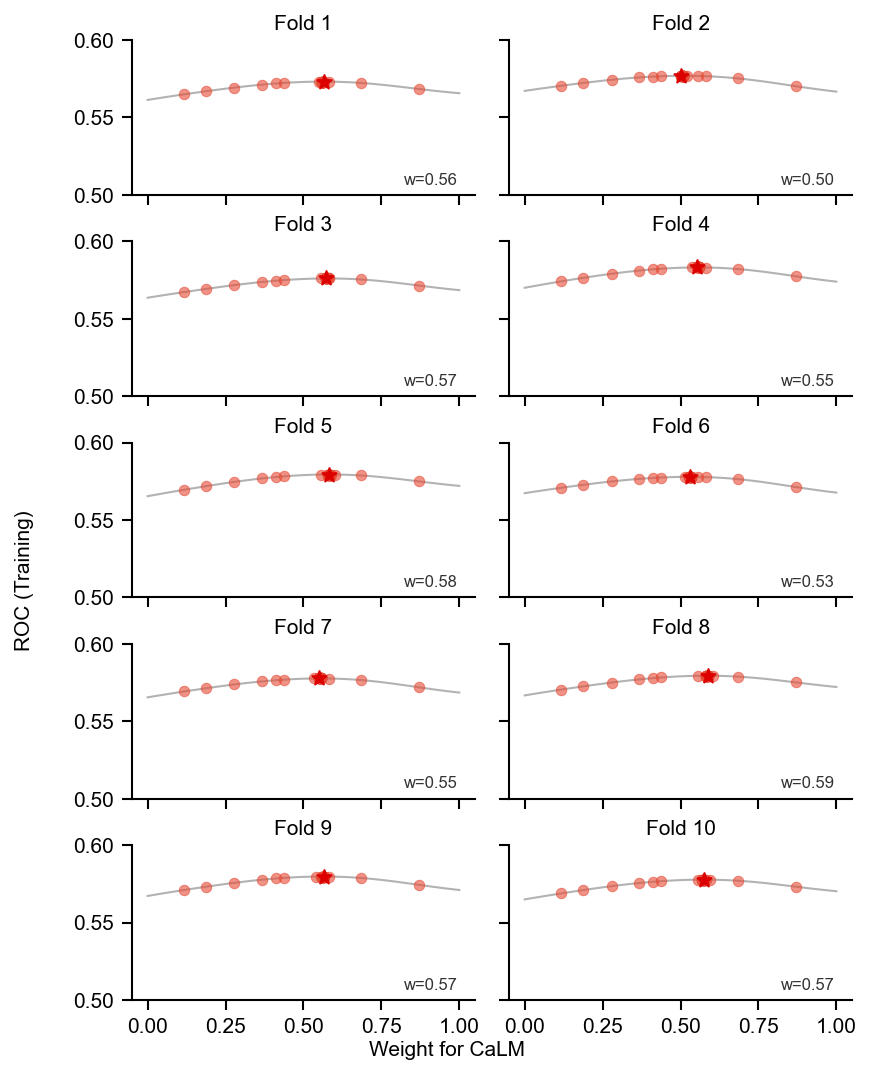

In [23]:
plot_fold_grid(results)

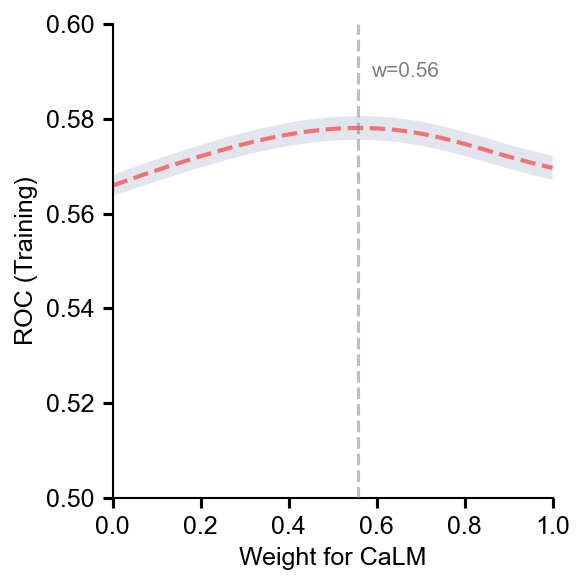

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

def style_ax(ax):

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=5, colors='black')


def plot_aggregated_landscape(results):

    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
    style_ax(ax)

    w_grid = results['BO_History'][0]['w_grid']
    landscape_matrix = np.array([fold['roc_landscape'] for fold in results['BO_History']])
    best_ws = [fold['best_w'] for fold in results['BO_History']]

    mean_auc = np.mean(landscape_matrix, axis=0)
    std_auc = np.std(landscape_matrix, axis=0)
    mean_best_w = np.mean(best_ws)

    ax.plot(w_grid, mean_auc, color='red', lw=2, alpha = 0.5, linestyle='--')

    ax.fill_between(w_grid, mean_auc - std_auc, mean_auc + std_auc,
                    color=colors['shade'], alpha=0.15, edgecolor='none')

    ax.axvline(mean_best_w, color='gray', linestyle='--', alpha=0.5, lw=1.5, zorder=5)

    text_x = mean_best_w + 0.03
    text_y = 0.59
    ha_align = 'left'

    if mean_best_w > 0.75:
        text_x = mean_best_w - 0.03
        ha_align = 'right'

    ax.text(text_x,
            text_y,
            f'w={mean_best_w:.2f}',
            color='gray',
            fontsize=10,
            fontweight='bold',
            ha=ha_align,
            va='center',
            )

    ax.set_ylim(0.5, 0.6)
    ax.set_xlim(0, 1)

    ax.set_xlabel(r'Weight for CaLM', fontsize=12)
    ax.set_ylabel('ROC (Training)', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_aggregated_landscape(results)